## Geospatial Analysis of Sacramento Region for new Pizzeria

### Week 5 Assignment: Battle of the Neighborhoods

My clients are moving from the east coast back to Sacramento, CA to be close with their extended family. They currently run a successful Pizzeria in New Jersey which they will be selling to fund a new restaurant in the Sacramento region. They have hired my consulting firm to provide assistance to help them determine what part of the region would be the ideal spot to open their new restaurant. Optimally, they would like to open their restaurant in a region that is near event venues, corporate centers and recreational activities while also minimizing competition by opening in an area that lacks in current Pizzeria restaurants.  They really love downtown Sacramento, but they also hear the entire region is growing and there may be great opportunities within a 20 mile radius of the city.

- __Part 1 explore locations and venues within the City of Sacramento__   
   



- __Part 2 explore regions within 20 miles of Sacramento__
    - Look at U.S. Consensus data for top 20 most populated cities near Sacramento
    - Explore locations and venues within these top 20 cities

# __PART 1: THE CITY OF SACRAMENTO__

In [1]:
import itertools
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import json 
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
!pip install random2
from IPython.display import HTML
import random

print('Libraries imported.')


Libraries imported.


Hidden hide_toggle function:

In [2]:
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

## Let's Explore the City of Sacramento First 
- I identified a website that defined the __13 Top-Rated Tourist Attractions__ & Things to Do in the city of Sacramento, CA
    - URL: https://www.planetware.com/tourist-attractions-/sacramento-us-ca-sc.htm   
   


- I thought these __ATTRACTIONS__ would be a great starting point in our investigation for my clients:
    - Explore the Area around each one of these top Attractions
    - Group the neaby venues into categories and rank them based on their popularity (most frequented)
    - perform a cluster analysis using K-means clustering and try to get additional insight on venue categories 

In [3]:
# Top 13 Top-Rated Tourist Attractions website, read with BeautifulSoup

url = urlopen(r"https://www.planetware.com/tourist-attractions-/sacramento-us-ca-sc.htm")
soup = BeautifulSoup(url,  "html.parser") #soup = BeautifulSoup(url, 'lxml')
soup

#hides soup output to spare viewer of notebook
hide_toggle()



In [4]:
#Scrape Attraction Names from website

Attraction_Name = []

for div in soup.find_all('div', class_='article_block site'):
    Attraction_Name.append(div.find_all('h2')[0].get_text().strip('\n'))

for i in range(len(Attraction_Name)):
    Attraction_Name[i]= Attraction_Name[i][4:].strip(',')

for i in range(len(Attraction_Name)):
    if i == 9 or i == 10 or i == 11:
        Attraction_Name[i] = Attraction_Name[i][1:]
    else:
        Attraction_Name[i] = Attraction_Name[i][0:]
        
Attraction_Name = Attraction_Name[:-2]
Attraction_Name

['California State Railroad Museum',
 'State Capitol',
 'Crocker Museum of Art',
 'Old Sacramento',
 "Sutter's Fort State Historic Park",
 'California Automobile Museum',
 'Fairytale Town',
 'Sacramento Zoo',
 'Cathedral of the Blessed Sacrament',
 'California State Indian Museum State Historic Park',
 'Midtown',
 'American River Bike Trail/Jedediah Smith Memorial Trail',
 'Leland Stanford Mansion State Historical Park']

In [5]:
#Some of the attractions failed my search to geolocator. So as my loop failed, I identified and had to update the culprits with code
#These are the Attractions that required an updated name before the geolocator identified the long, Lat coordinates

Attraction_Name[1]= 'Capital Park Sacramento'
Attraction_Name[2]= 'Sacramento Crocker Museum'
Attraction_Name[8]= 'Cathedral of the Blessed Sacrament Sacramento'
Attraction_Name[9]= 'California State Indian Museum'
Attraction_Name[10]= 'Midtown 1915 O St, Sacramento, CA 95811'
Attraction_Name[11]= 'American River Bike Trail'
Attraction_Name

['California State Railroad Museum',
 'Capital Park Sacramento',
 'Sacramento Crocker Museum',
 'Old Sacramento',
 "Sutter's Fort State Historic Park",
 'California Automobile Museum',
 'Fairytale Town',
 'Sacramento Zoo',
 'Cathedral of the Blessed Sacrament Sacramento',
 'California State Indian Museum',
 'Midtown 1915 O St, Sacramento, CA 95811',
 'American River Bike Trail',
 'Leland Stanford Mansion State Historical Park']

In [6]:
type(Attraction_Name)

list

In [7]:
# Used geolocator and used a loop to search for, intentify longitude and latitude, then populate a dataframe
Latitude = []
Longitude = []

for name in Attraction_Name:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(name)
    latitude = location.latitude
    longitude = location.longitude
    print(f'{name}: [{latitude}, {longitude}]')
    Latitude.append(latitude)
    Longitude.append(longitude)        
        
print('\n')
print('DataFrames Latitude & Longitude have been updated.')

California State Railroad Museum: [38.58497285, -121.50430271143694]
Capital Park Sacramento: [14.5699932, 121.0202179]
Sacramento Crocker Museum: [38.5771169, -121.5061707]
Old Sacramento: [38.5810606, -121.4938951]
Sutter's Fort State Historic Park: [38.57258175, -121.4712809691325]
California Automobile Museum: [38.570361750000004, -121.51175375667944]
Fairytale Town: [38.53972325, -121.50109474953933]
Sacramento Zoo: [38.539187150000004, -121.50436114980647]
Cathedral of the Blessed Sacrament Sacramento: [38.57900675, -121.49200235302118]
California State Indian Museum: [38.57302335, -121.47172438081367]
Midtown 1915 O St, Sacramento, CA 95811: [38.5723431, -121.4875272]
American River Bike Trail: [38.5802621, -121.4179232]
Leland Stanford Mansion State Historical Park: [38.5762942, -121.4977331]


DataFrames Latitude & Longitude have been updated.


In [8]:
#fix lat long coordinates for Capital Park since geolocator came up with a location in Phillipines

Latitude[1] = float(38.57605)
Longitude[1] = float(-121.49072)
print(Latitude[1])
print(Longitude[1])

38.57605
-121.49072


In [9]:
#Time to merge the three seperate lists into one
Attractions = pd.DataFrame({'Attraction':Attraction_Name, 'Latitude':Latitude, 'Longitude': Longitude})
Attractions

,Attraction,Latitude,Longitude
0,California State Railroad Museum,38.584973,-121.504303
1,Capital Park Sacramento,38.576050,-121.490720
2,Sacramento Crocker Museum,38.577117,-121.506171
3,Old Sacramento,38.581061,-121.493895
4,Sutter's Fort State Historic Park,38.572582,-121.471281
5,California Automobile Museum,38.570362,-121.511754
6,Fairytale Town,38.539723,-121.501095
7,Sacramento Zoo,38.539187,-121.504361
8,Cathedral of the Blessed Sacrament Sacramento,38.579007,-121.492002
9,California State Indian Museum,38.573023,-121.471724


In [10]:
Attractions.shape

(13, 3)

## Use location coordinates to explore Attractions on an interactive map

In [11]:
# Identify the Latitude, Longitude for Sacramento, CA

address = 'Sacramento, CA'

geolocator = Nominatim(user_agent="coursera")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates for Sacramento are {}, {}.'.format(latitude, longitude))

The geograpical coordinates for Sacramento are 38.5810606, -121.4938951.


In [12]:
# Create a general map of Sacramento
map_sac = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(Attractions['Latitude'], Attractions['Longitude'], Attractions['Attraction']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sac)  
    
map_sac

In [13]:


# Lets explore the venues that surround each of these Attractions
# We will do this using Foursquare


CLIENT_ID = 'SEB12VRXXLTFKQYNSB1DM2LAZEHFK2TVS02TL20ZYWH3IMSN' # your Foursquare ID
CLIENT_SECRET = '3E3LQBASDCDZAZOMI4JJRSLVFG45JOXXMFPIHKG1FF1ZM3Z4' # your Foursquare Secret
ACCESS_TOKEN = 'KSSMIWCOS5KDN4UV4KBSAAKZC2XOMHQEEWP01IAS4M2HYIH1' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails: <Hidden>')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)


hide_toggle()

Your credentails: <Hidden>


## Now let's identify the top 100 venues around each Attraction

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
sac_venues = getNearbyVenues(names=Attractions['Attraction'], 
                                 latitudes=Attractions['Latitude'], 
                                 longitudes=Attractions['Longitude'], 
                                 radius=500)

California State Railroad Museum
Capital Park Sacramento
Sacramento Crocker Museum
Old Sacramento
Sutter's Fort State Historic Park
California Automobile Museum
Fairytale Town
Sacramento Zoo
Cathedral of the Blessed Sacrament Sacramento
California State Indian Museum
Midtown 1915 O St, Sacramento, CA 95811
American River Bike Trail
Leland Stanford Mansion State Historical Park


In [16]:
# We identified 549 venues are within 500 feet from all 13 Attractions!
sac_venues.shape

(549, 7)

In [17]:
sac_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,California State Railroad Museum,38.584973,-121.504303,California State Railroad Museum,38.584462,-121.504015,History Museum
1,California State Railroad Museum,38.584973,-121.504303,Luis Jr.'s,38.584096,-121.503875,Mexican Restaurant
2,California State Railroad Museum,38.584973,-121.504303,Vega's Night Club & Sports Bar,38.583971,-121.503882,Nightclub
3,California State Railroad Museum,38.584973,-121.504303,The Chefs' Olive Mix,38.583265,-121.504095,Gourmet Shop
4,California State Railroad Museum,38.584973,-121.504303,The Other Office,38.583360,-121.504121,Dive Bar


In [18]:
print('There are {} uniques categories of venues.'.format(len(sac_venues['Venue Category'].unique())))

There are 122 uniques categories of venues.


## Lets get a count of how many venues are within 500 feet of each Attraction:

- There looks to be many venues by Capital Park, the Cathedral, in Old Sac and by the Railroad Museum
- The Caliornia Automobile Museum, the Crocker Museum and the American River Bike Trail seem to be more isolated with less venues

In [19]:
sac_venues.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
American River Bike Trail,14,14,14,14,14,14
California Automobile Museum,5,5,5,5,5,5
California State Indian Museum,35,35,35,35,35,35
California State Railroad Museum,64,64,64,64,64,64
Capital Park Sacramento,100,100,100,100,100,100
Cathedral of the Blessed Sacrament Sacramento,69,69,69,69,69,69
Fairytale Town,33,33,33,33,33,33
Leland Stanford Mansion State Historical Park,36,36,36,36,36,36
"Midtown 1915 O St, Sacramento, CA 95811",35,35,35,35,35,35


## Let's analyse City of Sacramento Attractions and Venues even further!
- First, I will identify the Top 5 most frequented venue categories around each Attraction
- Then we can discover the top 10 most popular venues around each Attraction
- Finally, we can use K-means clustering to map out Attraction groupings to get more insight on the area

### With more insight, we can make a more informed decision on new Pizzeria location!

In [20]:
# First, lets identify the top 5 venue categories for each Attraction using one hot encoding
sac_onehot = pd.get_dummies(sac_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sac_onehot['Neighborhood'] =sac_venues['Neighborhood'] 

sac_onehot.shape

(549, 122)

In [21]:
sac_onehot.head()

,Accessories Store,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Garden,Bike Shop,Boat or Ferry,Boutique,Brasserie,Breakfast Spot,Bridal Shop,Building,Burger Joint,Bus Stop,Cafeteria,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Garden,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Lake,Laundry Service,Light Rail Station,Lounge,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Optical Shop,Park,Pedestrian Plaza,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Soup Place,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Street Food Gathering,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,California State Railroad Museum,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
#Find the Neighborhood column
sac_onehot.columns[81]

'Neighborhood'

In [23]:
# move neighborhood column to the first column
fixed_columns = [sac_onehot.columns[81]] + list(sac_onehot.columns[0:81]) + list(sac_onehot.columns[82:])
sac_onehot = sac_onehot[fixed_columns]

sac_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Garden,Bike Shop,Boat or Ferry,Boutique,Brasserie,Breakfast Spot,Bridal Shop,Building,Burger Joint,Bus Stop,Cafeteria,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Garden,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Lake,Laundry Service,Light Rail Station,Lounge,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Optical Shop,Park,Pedestrian Plaza,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Soup Place,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Street Food Gathering,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery,Zoo,Zoo Exhibit
0,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,California State Railroad Museum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
#make sure i have the same number of rows and columns (494, 151)
sac_onehot.shape

(549, 122)

In [103]:
# get the mean value of each category around an Attraction
sac_grouped = sac_onehot.groupby('Neighborhood').mean().reset_index()
sac_grouped

,Neighborhood,Accessories Store,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Garden,Bike Shop,Boat or Ferry,Boutique,Brasserie,Breakfast Spot,Bridal Shop,Building,Burger Joint,Bus Stop,Cafeteria,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Garden,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Lake,Laundry Service,Light Rail Station,Lounge,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Optical Shop,Park,Pedestrian Plaza,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Soup Place,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Street Food Gathering,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery,Zoo,Zoo Exhibit
0,American River Bike Trail,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,California Automobile Museum,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,California State Indian Museum,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.028571,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.

In [26]:
sac_grouped.shape

(13, 122)

## Top 5 Most Popular Venue Categories for each Attraction location!

In [27]:
# identify the most frequent categories of venues in each Neighborhood
num_top_venues = 5

for hood in sac_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sac_grouped[sac_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----American River Bike Trail----
                 venue  freq
0               Bakery  0.14
1       Sandwich Place  0.07
2         Optical Shop  0.07
3                Diner  0.07
4  Arts & Crafts Store  0.07


----California Automobile Museum----
                 venue  freq
0               Museum   0.4
1         Intersection   0.2
2                  Gym   0.2
3    Electronics Store   0.2
4  Monument / Landmark   0.0


----California State Indian Museum----
                venue  freq
0  Mexican Restaurant  0.09
1         Coffee Shop  0.06
2         Pizza Place  0.06
3      Sandwich Place  0.03
4       Deli / Bodega  0.03


----California State Railroad Museum----
                 venue  freq
0  American Restaurant  0.08
1       History Museum  0.06
2   Seafood Restaurant  0.05
3        Train Station  0.05
4                  Bar  0.05


----Capital Park Sacramento----
                 venue  freq
0          Coffee Shop  0.08
1  American Restaurant  0.08
2       Sandwich Place  0.07
3  

## Time to identify the top 10 most popular VENUES around each of the Attractions!

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [104]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sac_grouped['Neighborhood']

for ind in np.arange(sac_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sac_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.rename(columns={"Neighborhood":"Attraction"}, inplace=True)
neighborhoods_venues_sorted

,Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,American River Bike Trail,Bakery,Optical Shop,Sushi Restaurant,American Restaurant,Hotpot Restaurant,Arts & Crafts Store,Mobile Phone Shop,Hotel,Sandwich Place,Salon / Barbershop
1,California Automobile Museum,Museum,Intersection,Gym,Electronics Store,Zoo Exhibit,Food & Drink Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega
2,California State Indian Museum,Mexican Restaurant,Pizza Place,Coffee Shop,Beer Garden,Optical Shop,Laundry Service,Shoe Store,Breakfast Spot,Convenience Store,State / Provincial Park
3,California State Railroad Museum,American Restaurant,History Museum,Gift Shop,Train Station,Bar,Seafood Restaurant,Pizza Place,Dessert Shop,Snack Place,Cocktail Bar
4,Capital Park Sacramento,Coffee Shop,American Restaurant,Sandwich Place,Hotel,Nightclub,Sushi Restaurant,Café,Seafood Restaurant,Chinese Restaurant,Pizza Place
5,Cathedral of the Blessed Sacrament Sacramento,Coffee Shop,American Restaurant,Hotel,Sandwich Place,Nightclub,Sushi Restaurant,Lounge,Movie Theater,Chinese Restaurant,Deli / Bodega
6,Fairytale Town,Zoo Exhibit,Theme Park Ride / Attraction,Bakery,Snack Place,Grocery Store,Zoo,Golf Course,Gift Shop,Lake,Park
7,Leland Stanford Mansion State Historical Park,Coffee Shop,Mexican Restaurant,Café,Italian Restaurant,Gym / Fitness Center,Museum,Mediterranean Restaurant,New American Restaurant,Nightclub,Park
8,"Midtown 1915 O St, Sacramento, CA 95811",American Restaurant,Coffee Shop,Pizza Place,Park,Sandwich Place,Mexican Restaurant,Burger Joint,Seafood Restaurant,Restaurant,Café
9,Old Sacramento,Coffee Shop,Hotel,American Restaurant,Sandwich Place,Deli / Bodega,Sushi Restaurant,Mexican Restaurant,Movie Theater,Candy Store,Bridal Shop


## Let's use K-means Clustering algorithm to create correlated clusters/groupings to gain new insight

In [30]:
# set number of clusters
kclusters = 5

sac_grouped_clustering = sac_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sac_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 4, 1, 1, 1, 2, 1, 1, 1], dtype=int32)

In [31]:
sac_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Garden,Bike Shop,Boat or Ferry,Boutique,Brasserie,Breakfast Spot,Bridal Shop,Building,Burger Joint,Bus Stop,Cafeteria,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Garden,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Lake,Laundry Service,Light Rail Station,Lounge,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Optical Shop,Park,Pedestrian Plaza,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Soup Place,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Street Food Gathering,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery,Zoo,Zoo Exhibit
0,American River Bike Trail,0.000000,0.071429,0.0,0.071429,0.000000,0.0,0.0,0.142857,0.000000,0.000000,0.0,0.0,0.000000,0.071429,0.000000,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.071429,0.00000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.071429,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.071429,0.00,0.000000,0.071429,0.0,0.00,0.0,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.071429,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.071429,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.071429,0.071429,0.000000,0.00,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0
1,California Automobile Museum,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.2,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.200000,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.2,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.40,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0
2,California State Indian Museum,0.000000,0.028571,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.028571,0.028571,0.0,0.0,0.028571,0.000000,0.000000,0.0,0.0,0.028571,0.00,0.00,0.028571,0.00,0.0,0.000000,0.000000,0.000000,0.00000,0.057143,0.000000,0.00,0.028571,0.0,0.00,0.0,0.028571,0.028571,0.028571,0.028571,0.00000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.028571,0.0000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.0,0.00,0.028571,0.00,0.0,0.000000,0.0,0.0,0.028571,0.000000,0.028571,0.00,0.085714,0.000000,0.028571,0.00,0.000000,0.00,0.028571,0.028

In [32]:
sac_grouped_clustering.head()

,Accessories Store,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Garden,Bike Shop,Boat or Ferry,Boutique,Brasserie,Breakfast Spot,Bridal Shop,Building,Burger Joint,Bus Stop,Cafeteria,Café,Candy Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Convenience Store,Cosmetics Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food & Drink Shop,French Restaurant,Frozen Yogurt Shop,Garden,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Lake,Laundry Service,Light Rail Station,Lounge,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Optical Shop,Park,Pedestrian Plaza,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Soup Place,Sports Bar,Sports Club,State / Provincial Park,Steakhouse,Street Food Gathering,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Wine Bar,Winery,Zoo,Zoo Exhibit
0,0.000000,0.071429,0.0,0.071429,0.000000,0.0,0.0,0.142857,0.000000,0.000000,0.0,0.0,0.000000,0.071429,0.000000,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.071429,0.00000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.071429,0.000000,0.00,0.0,0.000000,0.000000,0.0000,0.071429,0.00,0.000000,0.071429,0.0,0.00,0.0,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.071429,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.071429,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.071429,0.071429,0.000000,0.00,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.2,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.200000,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.2,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.40,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0
2,0.000000,0.028571,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.028571,0.028571,0.0,0.0,0.028571,0.000000,0.000000,0.0,0.0,0.028571,0.00,0.00,0.028571,0.00,0.0,0.000000,0.000000,0.000000,0.00000,0.057143,0.000000,0.00,0.028571,0.0,0.00,0.0,0.028571,0.028571,0.028571,0.028571,0.00000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.028571,0.0000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.0,0.00,0.028571,0.00,0.0,0.000000,0.0,0.0,0.028571,0.000000,0.028571,0.00,0.085714,0.000000,0.028571,0.00,0.000000,0.00,0.028571,0.028571,0.028571,0.028571,0.000000,0.00,0.028571,0.057143,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.028

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sac_merged = Attractions



In [34]:
sac_merged.head()

,Attraction,Latitude,Longitude
0,California State Railroad Museum,38.584973,-121.504303
1,Capital Park Sacramento,38.576050,-121.490720
2,Sacramento Crocker Museum,38.577117,-121.506171
3,Old Sacramento,38.581061,-121.493895
4,Sutter's Fort State Historic Park,38.572582,-121.471281


In [35]:
neighborhoods_venues_sorted

,Cluster Labels,Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,American River Bike Trail,Bakery,Optical Shop,Sushi Restaurant,American Restaurant,Hotpot Restaurant,Arts & Crafts Store,Mobile Phone Shop,Hotel,Sandwich Place,Salon / Barbershop
1,0,California Automobile Museum,Museum,Intersection,Gym,Electronics Store,Zoo Exhibit,Food & Drink Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega
2,4,California State Indian Museum,Mexican Restaurant,Pizza Place,Coffee Shop,Beer Garden,Optical Shop,Laundry Service,Shoe Store,Breakfast Spot,Convenience Store,State / Provincial Park
3,1,California State Railroad Museum,American Restaurant,History Museum,Gift Shop,Train Station,Bar,Seafood Restaurant,Pizza Place,Dessert Shop,Snack Place,Cocktail Bar
4,1,Capital Park Sacramento,Coffee Shop,American Restaurant,Sandwich Place,Hotel,Nightclub,Sushi Restaurant,Café,Seafood Restaurant,Chinese Restaurant,Pizza Place
5,1,Cathedral of the Blessed Sacrament Sacramento,Coffee Shop,American Restaurant,Hotel,Sandwich Place,Nightclub,Sushi Restaurant,Lounge,Movie Theater,Chinese Restaurant,Deli / Bodega
6,2,Fairytale Town,Zoo Exhibit,Theme Park Ride / Attraction,Bakery,Snack Place,Grocery Store,Zoo,Golf Course,Gift Shop,Lake,Park
7,1,Leland Stanford Mansion State Historical Park,Coffee Shop,Mexican Restaurant,Café,Italian Restaurant,Gym / Fitness Center,Museum,Mediterranean Restaurant,New American Restaurant,Nightclub,Park
8,1,"Midtown 1915 O St, Sacramento, CA 95811",American Restaurant,Coffee Shop,Pizza Place,Park,Sandwich Place,Mexican Restaurant,Burger Joint,Seafood Restaurant,Restaurant,Café
9,1,Old Sacramento,Coffee Shop,Hotel,American Restaurant,Sandwich Place,Deli / Bodega,Sushi Restaurant,Mexican Restaurant,Movie Theater,Candy Store,Bridal Shop


In [36]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,American River Bike Trail,Bakery,Optical Shop,Sushi Restaurant,American Restaurant,Hotpot Restaurant,Arts & Crafts Store,Mobile Phone Shop,Hotel,Sandwich Place,Salon / Barbershop
1,0,California Automobile Museum,Museum,Intersection,Gym,Electronics Store,Zoo Exhibit,Food & Drink Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega
2,4,California State Indian Museum,Mexican Restaurant,Pizza Place,Coffee Shop,Beer Garden,Optical Shop,Laundry Service,Shoe Store,Breakfast Spot,Convenience Store,State / Provincial Park
3,1,California State Railroad Museum,American Restaurant,History Museum,Gift Shop,Train Station,Bar,Seafood Restaurant,Pizza Place,Dessert Shop,Snack Place,Cocktail Bar
4,1,Capital Park Sacramento,Coffee Shop,American Restaurant,Sandwich Place,Hotel,Nightclub,Sushi Restaurant,Café,Seafood Restaurant,Chinese Restaurant,Pizza Place


In [37]:
# merge sac_grouped with sac data to add latitude/longitude for each neighborhood
sac_merged = sac_merged.join(neighborhoods_venues_sorted.set_index('Attraction'), on='Attraction')

sac_merged.head(40)   # check the last columns!

,Attraction,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,California State Railroad Museum,38.584973,-121.504303,1,American Restaurant,History Museum,Gift Shop,Train Station,Bar,Seafood Restaurant,Pizza Place,Dessert Shop,Snack Place,Cocktail Bar
1,Capital Park Sacramento,38.576050,-121.490720,1,Coffee Shop,American Restaurant,Sandwich Place,Hotel,Nightclub,Sushi Restaurant,Café,Seafood Restaurant,Chinese Restaurant,Pizza Place
2,Sacramento Crocker Museum,38.577117,-121.506171,1,History Museum,Italian Restaurant,Café,Sandwich Place,Cafeteria,Farmers Market,Park,Pedestrian Plaza,Comedy Club,Hotel
3,Old Sacramento,38.581061,-121.493895,1,Coffee Shop,Hotel,American Restaurant,Sandwich Place,Deli / Bodega,Sushi Restaurant,Mexican Restaurant,Movie Theater,Candy Store,Bridal Shop
4,Sutter's Fort State Historic Park,38.572582,-121.471281,4,Mexican Restaurant,Coffee Shop,Bar,Boutique,Burger Joint,Pizza Place,Gift Shop,Deli / Bodega,Salon / Barbershop,Diner
5,California Automobile Museum,38.570362,-121.511754,0,Museum,Intersection,Gym,Electronics Store,Zoo Exhibit,Food & Drink Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega
6,Fairytale Town,38.539723,-121.501095,2,Zoo Exhibit,Theme Park Ride / Attraction,Bakery,Snack Place,Grocery Store,Zoo,Golf Course,Gift Shop,Lake,Park
7,Sacramento Zoo,38.539187,-121.504361,2,Zoo Exhibit,Theme Park Ride / Attraction,Bakery,Snack Place,Grocery Store,Zoo,Gift Shop,Lake,Pharmacy,Chinese Restaurant
8,Cathedral of the Blessed Sacrament Sacramento,38.579007,-121.492002,1,Coffee Shop,American Restaurant,Hotel,Sandwich Place,Nightclub,Sushi Restaurant,Lounge,Movie Theater,Chinese Restaurant,Deli / Bodega
9,California State Indian Museum,38.573023,-121.471724,4,Mexican Restaurant,Pizza Place,Coffee Shop,Beer Garden,Optical Shop,Laundry Service,Shoe Store,Breakfast Spot,Convenience Store,State / Provincial Park


In [105]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sac_merged['Latitude'], sac_merged['Longitude'], sac_merged['Attraction'], sac_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1 California Automobile Museum Area:
- A Gym, A Cycle studio, a handful of shops
- Close to the freeway intersection which may be convenient for delivery services.
- Very close to Old Sacramento on the water, super popular among visitors and locals!

In [39]:
sac_merged.loc[sac_merged['Cluster Labels'] == 0, sac_merged.columns[[0] + list(range(4, sac_merged.shape[1]))]]


,Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,California Automobile Museum,Museum,Intersection,Gym,Electronics Store,Zoo Exhibit,Food & Drink Shop,Credit Union,Creperie,Cycle Studio,Deli / Bodega


### Cluster 2 Capital Area, Coffee Shops, Resaurants, Bars, Pizzerias:
- This area is close to our State Capital, which is always hustling with California lawmakers and businesses.
- Definitely would be busy at lunch time catering to the State government businesses
- A Pizzeria in this area would benefit from high traffic, however there would be competing Pizzerias in this cluster
- There are many different restaurant choices in this area as well, lots of competition for that traffic!

In [40]:
sac_merged.loc[sac_merged['Cluster Labels'] == 1, sac_merged.columns[[0] + list(range(4, sac_merged.shape[1]))]]

,Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,California State Railroad Museum,American Restaurant,History Museum,Gift Shop,Train Station,Bar,Seafood Restaurant,Pizza Place,Dessert Shop,Snack Place,Cocktail Bar
1,Capital Park Sacramento,Coffee Shop,American Restaurant,Sandwich Place,Hotel,Nightclub,Sushi Restaurant,Café,Seafood Restaurant,Chinese Restaurant,Pizza Place
2,Sacramento Crocker Museum,History Museum,Italian Restaurant,Café,Sandwich Place,Cafeteria,Farmers Market,Park,Pedestrian Plaza,Comedy Club,Hotel
3,Old Sacramento,Coffee Shop,Hotel,American Restaurant,Sandwich Place,Deli / Bodega,Sushi Restaurant,Mexican Restaurant,Movie Theater,Candy Store,Bridal Shop
8,Cathedral of the Blessed Sacrament Sacramento,Coffee Shop,American Restaurant,Hotel,Sandwich Place,Nightclub,Sushi Restaurant,Lounge,Movie Theater,Chinese Restaurant,Deli / Bodega
10,"Midtown 1915 O St, Sacramento, CA 95811",American Restaurant,Coffee Shop,Pizza Place,Park,Sandwich Place,Mexican Restaurant,Burger Joint,Seafood Restaurant,Restaurant,Café
12,Leland Stanford Mansion State Historical Park,Coffee Shop,Mexican Restaurant,Café,Italian Restaurant,Gym / Fitness Center,Museum,Mediterranean Restaurant,New American Restaurant,Nightclub,Park


### Cluster 3 Sac Zoo Area, Theme Park, Shops and Recreation:
- This cluster is far from Sacramento City Center, so the foot traffic wouldn't be as high
- Recreational Lake and Golf Course and just a few shops and restaurants
- Patrons tend to eat while inside the Zoo or Theme Park
- May not be the best fit for a new Pizzeria

In [41]:
sac_merged.loc[sac_merged['Cluster Labels'] == 2, sac_merged.columns[[0] + list(range(4, sac_merged.shape[1]))]]

,Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Fairytale Town,Zoo Exhibit,Theme Park Ride / Attraction,Bakery,Snack Place,Grocery Store,Zoo,Golf Course,Gift Shop,Lake,Park
7,Sacramento Zoo,Zoo Exhibit,Theme Park Ride / Attraction,Bakery,Snack Place,Grocery Store,Zoo,Gift Shop,Lake,Pharmacy,Chinese Restaurant


### Cluster 4 Bike Trail Area, Recreation, Restaurants and Shops:
- This area is great for outdoor recreation
- A few shops and restaurants, and no popular Pizzerias
- Foot traffic would be lighter here than in the city center

In [42]:
sac_merged.loc[sac_merged['Cluster Labels'] == 3, sac_merged.columns[[0] + list(range(4, sac_merged.shape[1]))]]

,Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,American River Bike Trail,Bakery,Optical Shop,Sushi Restaurant,American Restaurant,Hotpot Restaurant,Arts & Crafts Store,Mobile Phone Shop,Hotel,Sandwich Place,Salon / Barbershop


### Cluster 5 Crocker Museum Area, Coffee Shops, Restaurants, Shops & Park:
- There isnt a popular Pizzeria in the immediate area according to my analysis
- This is near highway, which could be convenient for Pizza delivery services
- The Park and Farmers Market is always a big draw

In [43]:
sac_merged.loc[sac_merged['Cluster Labels'] == 4, sac_merged.columns[[0] + list(range(4, sac_merged.shape[1]))]]

,Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Sutter's Fort State Historic Park,Mexican Restaurant,Coffee Shop,Bar,Boutique,Burger Joint,Pizza Place,Gift Shop,Deli / Bodega,Salon / Barbershop,Diner
9,California State Indian Museum,Mexican Restaurant,Pizza Place,Coffee Shop,Beer Garden,Optical Shop,Laundry Service,Shoe Store,Breakfast Spot,Convenience Store,State / Provincial Park




# Part 2 Explore Cities on the OUTSKIRTS of Sacramento


- Looking at U.S. Consensus data for top 20 most populated cities near Sacramento
- Comparing each of the cities population and median family income to see if there is any correlation

In [46]:
df = pd.read_csv(r"https://raw.githubusercontent.com/mkchrist/Coursera_Capstone/main/Sac_Region.csv")

# take a look at the dataset
df.head()

,City,Population,Median_Income
0,Elk Grove,174775,93780
1,Roseville,141500,89082
2,Citrus Heights,87796,62276
3,Davis,69413,69379
4,Folsom,81328,114405


In [47]:
df = df.sort_values(by=['Population'], ascending=False).reset_index()
df

,index,City,Population,Median_Income
0,0,Elk Grove,174775,93780
1,1,Roseville,141500,89082
2,2,Citrus Heights,87796,62276
3,4,Folsom,81328,114405
4,5,Rancho Cordova,75087,65307
5,3,Davis,69413,69379
6,6,Rocklin,68823,98566
7,8,Yuba City,67010,56816
8,7,Woodland,60548,69612
9,17,West Sacramento,53519,70699


[Text(0, 0.5, 'Min, Middle, Max Values')]

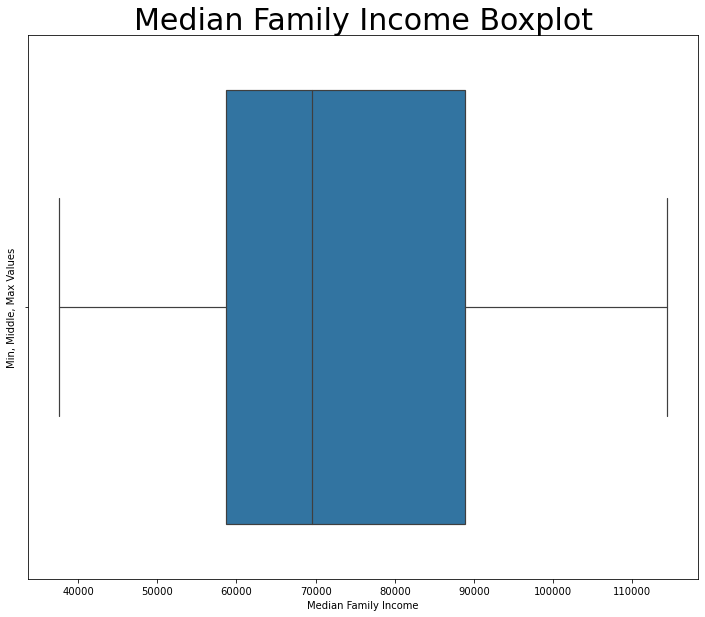

In [48]:
fig, ax = pyplot.subplots(figsize=(12,10))
plot=sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":20, "axes.titlesize":30, "axes.labelsize":20})
#sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
ax.set_title("Median Family Income Boxplot")
ax=sns.boxplot(x=df["Median_Income"])
ax.set(xlabel="Median Family Income")
ax.set(ylabel="Min, Middle, Max Values")


[Text(0, 0.5, 'Min, Middle, Max Values')]

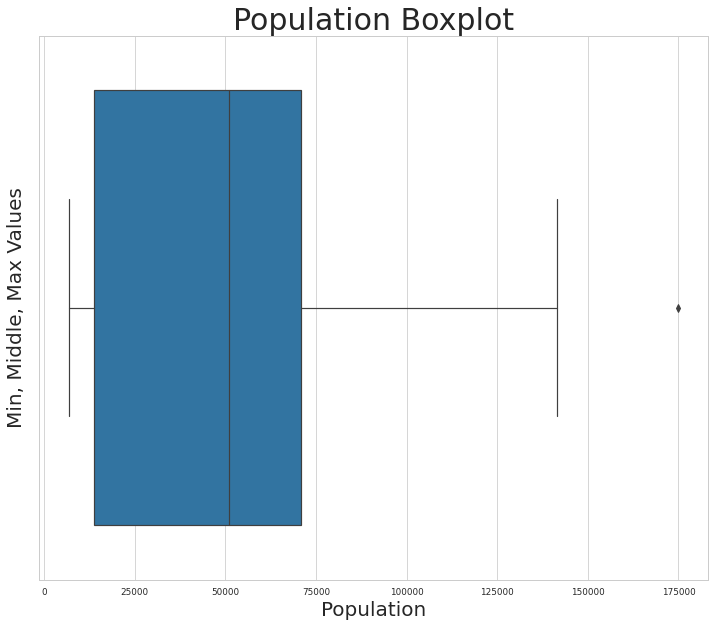

In [49]:
fig, ax = pyplot.subplots(figsize=(12,10))
plot=sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":30,"axes.labelsize":20})
#sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
ax.set_title("Population Boxplot")
ax=sns.boxplot(x=df["Population"])
ax.set(xlabel="Population")
ax.set(ylabel="Min, Middle, Max Values")

[Text(0, 0.5, '# of Cities')]

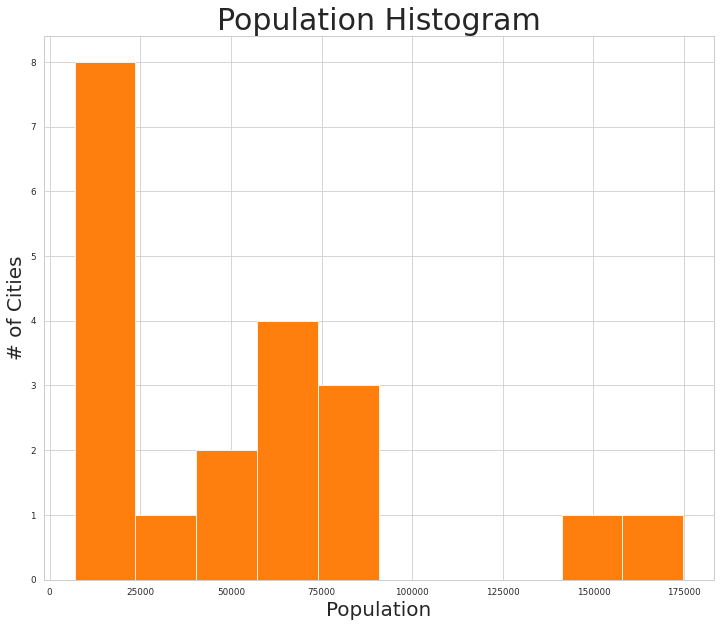

In [50]:
fig, ax = pyplot.subplots(figsize=(12,10))
df['Population'].plot(kind='hist')
df['Population'].plot.hist()
ax.set_title("Population Histogram")
ax.set(xlabel="Population")
ax.set(ylabel="# of Cities")


[Text(0, 0.5, '# of Cities')]

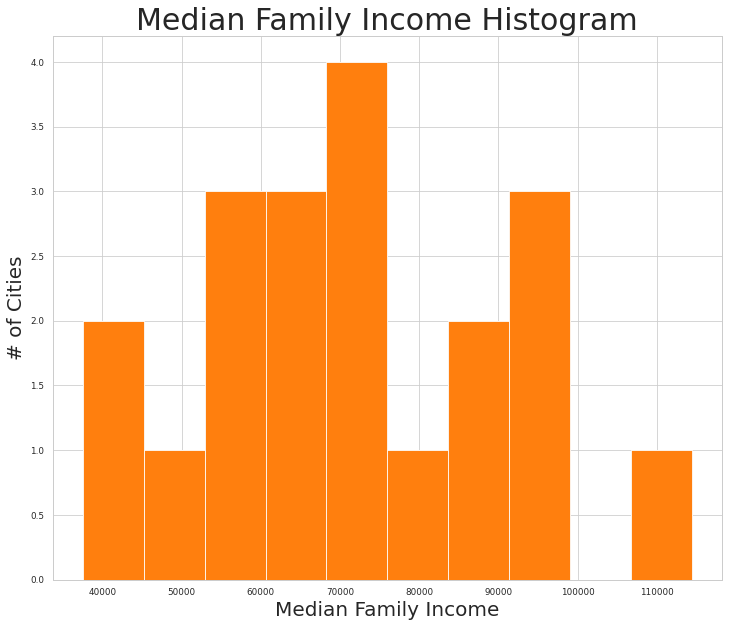

In [51]:
fig, ax = pyplot.subplots(figsize=(12,10))
df['Median_Income'].plot(kind='hist')
df['Median_Income'].plot.hist()
ax.set_title("Median Family Income Histogram")
ax.set(xlabel="Median Family Income")
ax.set(ylabel="# of Cities")



[Text(0, 0.5, 'Median Family Income')]

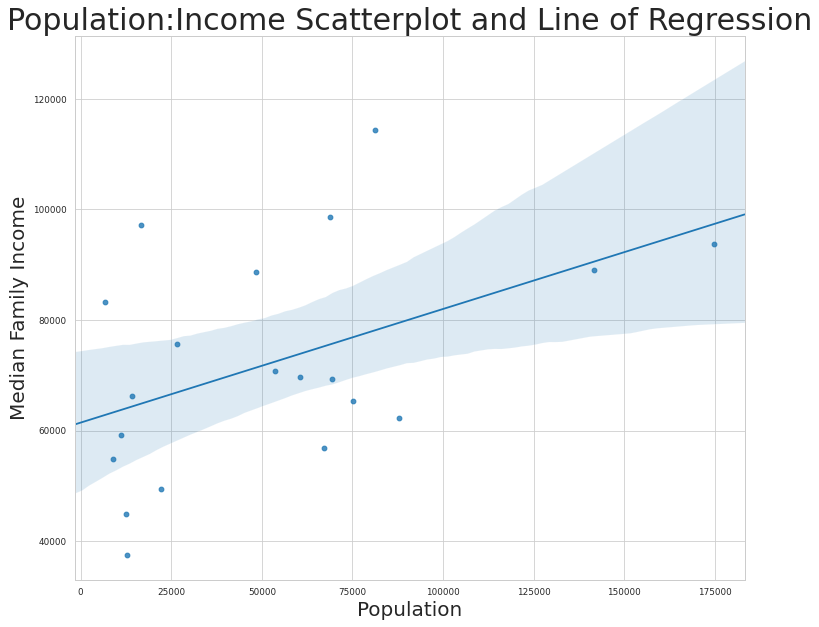

In [52]:
fig, ax = pyplot.subplots(figsize=(12,10))
plot=sns.regplot(x="Population", y='Median_Income', data=df)
ax.set_title("Population:Income Scatterplot and Line of Regression")
ax.set(xlabel="Population")
ax.set(ylabel="Median Family Income")

### Analysis of Population and Median Family Income:

- The Regression Plot on Population vs Median_Income suggests that there is a positive correlation between the two variables
- This means that the cities with a larger population, also have a larger median family income
- If you choose to build your Pizzeria in the outskirts of Sacramento, I suggest choosing one with a larger population.
- Let's chose the top 5 highest populated cities outside sacramento and explore them more closely...

# Top 5 largest populated cities to explore: 
1. Elk Grove...............(pop. 174,775)
2. Roseville................(pop. 141,500)
3. Citrus Heights........(pop... 87,796)
3. Folsom...................(pop... 81,328)
4. Rancho Cordova....(pop... 75,087)


## Explorations:
- First, I will identify the Top 5 most frequented venue categories around each City
- Then we can discover the top 10 most popular venues around each City
- Finally, we can use K-means clustering to map out meaningful groupings to gain new insights

In [55]:
df2 = pd.read_csv(r"https://raw.githubusercontent.com/mkchrist/Coursera_Capstone/main/Cities.csv")

# take a look at the dataset
df2.head()

,City
0,"Elk Grove, CA"
1,"Roseville, CA"
2,"Citrus Heights, CA"
3,"Davis, CA"
4,"Folsom, CA"


In [58]:
names = df2.values.tolist()
names

[['Elk Grove, CA'],
 ['Roseville, CA'],
 ['Citrus Heights, CA'],
 ['Davis, CA'],
 ['Folsom, CA'],
 ['Rancho Cordova, CA'],
 ['Rocklin, CA'],
 ['Woodland, CA'],
 ['Yuba City, CA'],
 ['Auburn, CA'],
 ['Galt, CA'],
 ['Grass Valley, CA'],
 ['Lincoln, CA'],
 ['Marysville, CA'],
 ['Placerville, CA'],
 ['South Lake Tahoe, CA'],
 ['Truckee, CA'],
 ['West Sacramento, CA'],
 ['Live Oak, CA'],
 ['Loomis, CA']]

In [59]:
# Used geolocator and used a loop to search for, intentify longitude and latitude, then populate a dataframe
Latitude2 = []
Longitude2 = []

for name in names:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(name)
    latitude = location.latitude
    longitude = location.longitude
    print(f'{name}: [{latitude}, {longitude}]')
    Latitude2.append(latitude)
    Longitude2.append(longitude)        
        
print('\n')
print('DataFrames Latitude2 & Longitude2 have been updated.')

['Elk Grove, CA']: [38.4087993, -121.3716178]
['Roseville, CA']: [38.7521235, -121.2880059]
['Citrus Heights, CA']: [38.7071247, -121.2810611]
['Davis, CA']: [38.545379, -121.7445835]
['Folsom, CA']: [38.6779591, -121.1760583]
['Rancho Cordova, CA']: [38.5890723, -121.302728]
['Rocklin, CA']: [38.7907339, -121.2357828]
['Woodland, CA']: [38.6786109, -121.7733285]
['Yuba City, CA']: [39.1404477, -121.6169108]
['Auburn, CA']: [38.8945939, -121.0739897]
['Galt, CA']: [38.2546373, -121.2999485]
['Grass Valley, CA']: [39.2190799, -121.0619462]
['Lincoln, CA']: [38.859829500000004, -121.34239205792437]
['Marysville, CA']: [39.1457247, -121.5913516]
['Placerville, CA']: [38.7296252, -120.798546]
['South Lake Tahoe, CA']: [38.9332411, -119.9843482]
['Truckee, CA']: [39.327962, -120.1832533]
['West Sacramento, CA']: [38.5804609, -121.530234]
['Live Oak, CA']: [39.2757232, -121.6599701]
['Loomis, CA']: [38.8212889, -121.1930041]


DataFrames Latitude2 & Longitude2 have been updated.


In [60]:
Cities = pd.DataFrame({'City':names, 'Latitude':Latitude2, 'Longitude': Longitude2})
Cities

,City,Latitude,Longitude
0,"[Elk Grove, CA]",38.408799,-121.371618
1,"[Roseville, CA]",38.752124,-121.288006
2,"[Citrus Heights, CA]",38.707125,-121.281061
3,"[Davis, CA]",38.545379,-121.744584
4,"[Folsom, CA]",38.677959,-121.176058
5,"[Rancho Cordova, CA]",38.589072,-121.302728
6,"[Rocklin, CA]",38.790734,-121.235783
7,"[Woodland, CA]",38.678611,-121.773329
8,"[Yuba City, CA]",39.140448,-121.616911
9,"[Auburn, CA]",38.894594,-121.073990


In [61]:
Cities=Cities.replace('\[','',regex=True).astype(str)
Cities=Cities.replace('\[','',regex=True).astype(str) 
Cities=Cities.replace('\'','',regex=True).astype(str) 
Cities=Cities.replace('\]','',regex=True).astype(str) 

In [62]:
Cities

,City,Latitude,Longitude
0,"Elk Grove, CA",38.4087993,-121.3716178
1,"Roseville, CA",38.7521235,-121.2880059
2,"Citrus Heights, CA",38.7071247,-121.2810611
3,"Davis, CA",38.545379,-121.7445835
4,"Folsom, CA",38.6779591,-121.1760583
5,"Rancho Cordova, CA",38.5890723,-121.302728
6,"Rocklin, CA",38.7907339,-121.2357828
7,"Woodland, CA",38.6786109,-121.7733285
8,"Yuba City, CA",39.1404477,-121.6169108
9,"Auburn, CA",38.8945939,-121.0739897


In [63]:
# Identify the Latitude, Longitude for Sacramento, CA

address = 'Sacramento, CA'

geolocator = Nominatim(user_agent="coursera")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates for Sacramento are {}, {}.'.format(latitude, longitude))

The geograpical coordinates for Sacramento are 38.5810606, -121.4938951.


In [64]:
# Create a general map of Sacramento
map2_sac = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(Attractions['Latitude'], Attractions['Longitude'], Attractions['Attraction']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sac)  
    
map2_sac

In [65]:


# Lets explore the venues that surround each of these Attractions
# We will do this using Foursquare

CLIENT_ID = 'SEB12VRXXLTFKQYNSB1DM2LAZEHFK2TVS02TL20ZYWH3IMSN' # your Foursquare ID
CLIENT_SECRET = '3E3LQBASDCDZAZOMI4JJRSLVFG45JOXXMFPIHKG1FF1ZM3Z4' # your Foursquare Secret
ACCESS_TOKEN = 'KSSMIWCOS5KDN4UV4KBSAAKZC2XOMHQEEWP01IAS4M2HYIH1' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails: <Hidden>')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)
hide_toggle()

Your credentails: <Hidden>


In [66]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [67]:
region_venues = getNearbyVenues(names=Cities['City'], 
                                 latitudes=Cities['Latitude'], 
                                 longitudes=Cities['Longitude'], 
                                 radius=5280)

Elk Grove, CA
Roseville, CA
Citrus Heights, CA
Davis, CA
Folsom, CA
Rancho Cordova, CA
Rocklin, CA
Woodland, CA
Yuba City, CA
Auburn, CA
Galt, CA
Grass Valley, CA
Lincoln, CA
Marysville, CA
Placerville, CA
South Lake Tahoe, CA
Truckee, CA
West Sacramento, CA
Live Oak, CA
Loomis, CA


In [68]:
# We identified 1681 venues are within 1 mile from all 20 Cities!
region_venues.shape

(1681, 7)

In [69]:
region_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Elk Grove, CA",38.4087993,-121.3716178,Dutch Bros. Coffee,38.408715,-121.384941,Coffee Shop
1,"Elk Grove, CA",38.4087993,-121.3716178,Brick House Restaurant & Catering,38.409295,-121.365853,American Restaurant
2,"Elk Grove, CA",38.4087993,-121.3716178,Palermo Ristorante Italiano,38.407947,-121.379830,Italian Restaurant
3,"Elk Grove, CA",38.4087993,-121.3716178,Drewski's Hot Rod Kitchen,38.408744,-121.363279,Food Truck
4,"Elk Grove, CA",38.4087993,-121.3716178,Thai Chili,38.408020,-121.381605,Thai Restaurant


In [70]:
print('There are {} uniques categories of venues.'.format(len(region_venues['Venue Category'].unique())))

There are 217 uniques categories of venues.


# Lets get a count of how many venues are within 1 mile of each city center:
- xxxxx
- xxxxx

In [71]:
region_venues.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Auburn, CA",100,100,100,100,100,100
"Citrus Heights, CA",100,100,100,100,100,100
"Davis, CA",89,89,89,89,89,89
"Elk Grove, CA",100,100,100,100,100,100
"Folsom, CA",100,100,100,100,100,100
"Galt, CA",44,44,44,44,44,44
"Grass Valley, CA",50,50,50,50,50,50
"Lincoln, CA",74,74,74,74,74,74
"Live Oak, CA",8,8,8,8,8,8


## Let's analyse City of Sacramento Attractions and Venues even further!
- First, I will identify the Top 5 most frequented venue categories around each Attraction
- Then we can discover the top 10 most popular venues around each Attraction
- Finally, we can use K-means clustering to map out Attraction groupings to get more insight on the area

In [72]:
# First, lets identify the top 5 venue categories for each Attraction using one hot encoding
region_onehot = pd.get_dummies(region_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
region_onehot['Neighborhood'] =region_venues['Neighborhood'] 

region_onehot.shape

(1681, 217)

In [73]:
region_onehot.head()

,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Animal Shelter,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Caribbean Restaurant,Casino,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Record Shop,Rental Car Location,Resort,Restaurant,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chairlift,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Elk Grove, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Elk Grove, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0

In [74]:
#Find the Neighborhood column
region_onehot.columns[147]

'Neighborhood'

In [75]:
# move neighborhood column to the first column
fixed_columns = [region_onehot.columns[147]] + list(region_onehot.columns[0:147]) + list(region_onehot.columns[148:])
region_onehot = region_onehot[fixed_columns]

region_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Animal Shelter,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Caribbean Restaurant,Casino,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Record Shop,Rental Car Location,Resort,Restaurant,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chairlift,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Elk Grove, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Elk Grove, CA",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Elk Grove, CA",0,0,0,0,0

In [76]:
#make sure i have the same number of rows and columns (1681, 218)
region_onehot.shape

(1681, 217)

In [77]:
# get the mean value of each category around an Attraction
region_grouped = region_onehot.groupby('Neighborhood').mean().reset_index()
region_grouped.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Animal Shelter,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Caribbean Restaurant,Casino,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Record Shop,Rental Car Location,Resort,Restaurant,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chairlift,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Auburn, CA",0.02,0.00,0.00,0.0,0.0,0.070000,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.01,0.01,0.000000,0.010000,0.020000,0.03,0.01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.040000,0.030000,0.0,0.000000,0.040000,0.0,0.000000,0.0,0.01,0.010000,0.00,0.0,0.0,0.01,0.00,0.02,0.0,0.00,0.060000,0.00,0.0,0.00,0.02,0.01,0.000000,0.01,0.000000,0.00,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.010000,0.020000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.010000,0.000000,0.000000,0.0,0.03,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.03000,0.00,0.010000,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.010000,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.01,0.010000,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.03000,0.000000,0.0,0.00,0.01,0.0,0.01,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.01,0.010000,0.000000,0.00,0.00,0.010000,0.04,0.06000,0.0,0.00,0.000000,0

In [78]:
region_grouped.shape

(20, 217)

## Top 5 Most Popular Venue Categories for each Attraction location!

In [79]:
# identify the most frequent categories of venues in each Neighborhood
num_top_venues = 5

for hood in region_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = region_grouped[region_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Auburn, CA----
                 venue  freq
0  American Restaurant  0.07
1          Pizza Place  0.06
2          Coffee Shop  0.06
3             Pharmacy  0.04
4       Sandwich Place  0.04


----Citrus Heights, CA----
                venue  freq
0       Grocery Store  0.06
1         Coffee Shop  0.05
2  Chinese Restaurant  0.04
3         Pizza Place  0.04
4      Ice Cream Shop  0.04


----Davis, CA----
                venue  freq
0                Park  0.09
1         Coffee Shop  0.07
2         Pizza Place  0.06
3       Grocery Store  0.06
4  Mexican Restaurant  0.06


----Elk Grove, CA----
                venue  freq
0         Coffee Shop  0.06
1         Pizza Place  0.05
2  Mexican Restaurant  0.05
3  Chinese Restaurant  0.03
4      Ice Cream Shop  0.03


----Folsom, CA----
                venue  freq
0  Mexican Restaurant  0.08
1         Coffee Shop  0.06
2       Grocery Store  0.06
3         Pizza Place  0.05
4            Pharmacy  0.04


----Galt, CA----
                  venu

## Time to identify the top 10 most popular VENUES around each of the Attractions!

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [81]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns1 = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns1.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns1.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods1_venues_sorted = pd.DataFrame(columns=columns1)
neighborhoods1_venues_sorted['Neighborhood'] = region_grouped['Neighborhood']

for ind in np.arange(region_grouped.shape[0]):
    neighborhoods1_venues_sorted.iloc[ind, 1:] = return_most_common_venues(region_grouped.iloc[ind, :], num_top_venues)

neighborhoods1_venues_sorted.rename(columns={"Neighborhood":"City"}, inplace=True)
neighborhoods1_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Auburn, CA",American Restaurant,Pizza Place,Coffee Shop,Trail,Pharmacy,Sandwich Place,Breakfast Spot,Burger Joint,Gas Station,Bar
1,"Citrus Heights, CA",Grocery Store,Coffee Shop,Pizza Place,Ice Cream Shop,Chinese Restaurant,Park,Mexican Restaurant,Italian Restaurant,Bar,Gym / Fitness Center
2,"Davis, CA",Park,Coffee Shop,Grocery Store,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Sushi Restaurant,Rental Car Location
3,"Elk Grove, CA",Coffee Shop,Mexican Restaurant,Pizza Place,Park,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Burger Joint,Ice Cream Shop,American Restaurant
4,"Folsom, CA",Mexican Restaurant,Grocery Store,Coffee Shop,Pizza Place,Pharmacy,Park,Café,Sushi Restaurant,Sandwich Place,Gym / Fitness Center


## Let's use K-means Clustering algorithm to create correlated clusters/groupings to gain new insight

In [82]:
# set number of clusters
kclusters = 5

region_grouped_clustering = region_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans1 = KMeans(n_clusters=kclusters, random_state=0).fit(region_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans1.labels_[0:10]

array([2, 2, 1, 2, 2, 1, 4, 2, 3, 2], dtype=int32)

In [83]:
region_grouped_clustering.head()

,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Animal Shelter,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Caribbean Restaurant,Casino,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Post Office,Pub,Record Shop,Rental Car Location,Resort,Restaurant,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chairlift,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0.02,0.00,0.00,0.0,0.0,0.070000,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.01,0.01,0.000000,0.010000,0.020000,0.03,0.01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.040000,0.030000,0.0,0.000000,0.040000,0.0,0.000000,0.0,0.01,0.010000,0.00,0.0,0.0,0.01,0.00,0.02,0.0,0.00,0.060000,0.00,0.0,0.00,0.02,0.01,0.000000,0.01,0.000000,0.00,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.010000,0.020000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.010000,0.000000,0.000000,0.0,0.03,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.03000,0.00,0.010000,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.010000,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.01,0.010000,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.03000,0.000000,0.0,0.00,0.01,0.0,0.01,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.01,0.010000,0.000000,0.00,0.00,0.010000,0.04,0.06000,0.0,0.00,0.000000,0.020000,0.00,0.00,0.010000

In [84]:
# add clustering labels
neighborhoods1_venues_sorted.insert(0, 'Cluster Labels', kmeans1.labels_)

region_merged = Cities

In [85]:
region_merged.head()

,City,Latitude,Longitude
0,"Elk Grove, CA",38.4087993,-121.3716178
1,"Roseville, CA",38.7521235,-121.2880059
2,"Citrus Heights, CA",38.7071247,-121.2810611
3,"Davis, CA",38.545379,-121.7445835
4,"Folsom, CA",38.6779591,-121.1760583


In [86]:
neighborhoods1_venues_sorted

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,"Auburn, CA",American Restaurant,Pizza Place,Coffee Shop,Trail,Pharmacy,Sandwich Place,Breakfast Spot,Burger Joint,Gas Station,Bar
1,2,"Citrus Heights, CA",Grocery Store,Coffee Shop,Pizza Place,Ice Cream Shop,Chinese Restaurant,Park,Mexican Restaurant,Italian Restaurant,Bar,Gym / Fitness Center
2,1,"Davis, CA",Park,Coffee Shop,Grocery Store,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Sushi Restaurant,Rental Car Location
3,2,"Elk Grove, CA",Coffee Shop,Mexican Restaurant,Pizza Place,Park,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Burger Joint,Ice Cream Shop,American Restaurant
4,2,"Folsom, CA",Mexican Restaurant,Grocery Store,Coffee Shop,Pizza Place,Pharmacy,Park,Café,Sushi Restaurant,Sandwich Place,Gym / Fitness Center
5,1,"Galt, CA",Fast Food Restaurant,Sandwich Place,Pizza Place,Pharmacy,Grocery Store,Park,Coffee Shop,Food Truck,Hotel,Mexican Restaurant
6,4,"Grass Valley, CA",Grocery Store,Coffee Shop,Pizza Place,American Restaurant,Bakery,Café,Italian Restaurant,Breakfast Spot,Sandwich Place,Steakhouse
7,2,"Lincoln, CA",Pizza Place,Sandwich Place,Chinese Restaurant,Grocery Store,Coffee Shop,Salon / Barbershop,Pharmacy,Bar,Sushi Restaurant,Park
8,3,"Live Oak, CA",Food,Grocery Store,Pizza Place,Market,Gas Station,Sandwich Place,Farmers Market,Candy Store,Convenience Store,Donut Shop
9,2,"Loomis, CA",Coffee Shop,Fast Food Restaurant,Brewery,Mexican Restaurant,Bar,American Restaurant,Pet Store,Grocery Store,Garden Center,Sandwich Place


In [87]:
# merge sac_grouped with sac data to add latitude/longitude for each neighborhood
region_merged = region_merged.join(neighborhoods1_venues_sorted.set_index('City'), on='City')

region_merged.head(40)   # check the last columns!

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Elk Grove, CA",38.4087993,-121.3716178,2,Coffee Shop,Mexican Restaurant,Pizza Place,Park,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Burger Joint,Ice Cream Shop,American Restaurant
1,"Roseville, CA",38.7521235,-121.2880059,2,Mexican Restaurant,American Restaurant,Grocery Store,Coffee Shop,Pizza Place,Fast Food Restaurant,Toy / Game Store,Sushi Restaurant,Chinese Restaurant,Cosmetics Shop
2,"Citrus Heights, CA",38.7071247,-121.2810611,2,Grocery Store,Coffee Shop,Pizza Place,Ice Cream Shop,Chinese Restaurant,Park,Mexican Restaurant,Italian Restaurant,Bar,Gym / Fitness Center
3,"Davis, CA",38.545379,-121.7445835,1,Park,Coffee Shop,Grocery Store,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Sushi Restaurant,Rental Car Location
4,"Folsom, CA",38.6779591,-121.1760583,2,Mexican Restaurant,Grocery Store,Coffee Shop,Pizza Place,Pharmacy,Park,Café,Sushi Restaurant,Sandwich Place,Gym / Fitness Center
5,"Rancho Cordova, CA",38.5890723,-121.302728,1,Park,Mexican Restaurant,Pizza Place,Coffee Shop,Chinese Restaurant,Gym,Grocery Store,Brewery,Burger Joint,Sandwich Place
6,"Rocklin, CA",38.7907339,-121.2357828,2,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Coffee Shop,Cosmetics Shop,Sushi Restaurant,Grocery Store,Brewery,Toy / Game Store
7,"Woodland, CA",38.6786109,-121.7733285,1,Coffee Shop,Mexican Restaurant,Grocery Store,Park,Deli / Bodega,Pizza Place,Gym,Brewery,Stadium,Sports Bar
8,"Yuba City, CA",39.1404477,-121.6169108,0,Mexican Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Pharmacy,Clothing Store,Steakhouse,Sushi Restaurant,Café,Italian Restaurant
9,"Auburn, CA",38.8945939,-121.0739897,2,American Restaurant,Pizza Place,Coffee Shop,Trail,Pharmacy,Sandwich Place,Breakfast Spot,Burger Joint,Gas Station,Bar


In [92]:
region_merged = region_merged.astype({"Latitude": float, "Longitude": float})

In [94]:
# create map
map1_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(region_merged['Latitude'], region_merged['Longitude'], region_merged['City'], region_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map1_clusters)
       
map1_clusters

### Cluster 1

In [95]:
region_merged.loc[region_merged['Cluster Labels'] == 0, region_merged.columns[[0] + list(range(4, region_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Yuba City, CA",Mexican Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Pharmacy,Clothing Store,Steakhouse,Sushi Restaurant,Café,Italian Restaurant
13,"Marysville, CA",Mexican Restaurant,Sandwich Place,Coffee Shop,Pharmacy,Convenience Store,Fast Food Restaurant,Sushi Restaurant,Clothing Store,Café,Italian Restaurant


### Cluster 2

In [96]:
region_merged.loc[region_merged['Cluster Labels'] == 1, region_merged.columns[[0] + list(range(4, region_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Davis, CA",Park,Coffee Shop,Grocery Store,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Sushi Restaurant,Rental Car Location
5,"Rancho Cordova, CA",Park,Mexican Restaurant,Pizza Place,Coffee Shop,Chinese Restaurant,Gym,Grocery Store,Brewery,Burger Joint,Sandwich Place
7,"Woodland, CA",Coffee Shop,Mexican Restaurant,Grocery Store,Park,Deli / Bodega,Pizza Place,Gym,Brewery,Stadium,Sports Bar
10,"Galt, CA",Fast Food Restaurant,Sandwich Place,Pizza Place,Pharmacy,Grocery Store,Park,Coffee Shop,Food Truck,Hotel,Mexican Restaurant


### Cluster 3

In [97]:
region_merged.loc[region_merged['Cluster Labels'] == 2, region_merged.columns[[0] + list(range(4, region_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Elk Grove, CA",Coffee Shop,Mexican Restaurant,Pizza Place,Park,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Burger Joint,Ice Cream Shop,American Restaurant
1,"Roseville, CA",Mexican Restaurant,American Restaurant,Grocery Store,Coffee Shop,Pizza Place,Fast Food Restaurant,Toy / Game Store,Sushi Restaurant,Chinese Restaurant,Cosmetics Shop
2,"Citrus Heights, CA",Grocery Store,Coffee Shop,Pizza Place,Ice Cream Shop,Chinese Restaurant,Park,Mexican Restaurant,Italian Restaurant,Bar,Gym / Fitness Center
4,"Folsom, CA",Mexican Restaurant,Grocery Store,Coffee Shop,Pizza Place,Pharmacy,Park,Café,Sushi Restaurant,Sandwich Place,Gym / Fitness Center
6,"Rocklin, CA",American Restaurant,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Coffee Shop,Cosmetics Shop,Sushi Restaurant,Grocery Store,Brewery,Toy / Game Store
9,"Auburn, CA",American Restaurant,Pizza Place,Coffee Shop,Trail,Pharmacy,Sandwich Place,Breakfast Spot,Burger Joint,Gas Station,Bar
12,"Lincoln, CA",Pizza Place,Sandwich Place,Chinese Restaurant,Grocery Store,Coffee Shop,Salon / Barbershop,Pharmacy,Bar,Sushi Restaurant,Park
14,"Placerville, CA",American Restaurant,Mexican Restaurant,Coffee Shop,Pizza Place,Grocery Store,Sandwich Place,Pharmacy,Fast Food Restaurant,Bank,Brewery
15,"South Lake Tahoe, CA",Hotel,American Restaurant,Coffee Shop,Pizza Place,Mexican Restaurant,Burger Joint,Brewery,Beach,Bar,Park
16,"Truckee, CA",Golf Course,Coffee Shop,Bar,Mexican Restaurant,American Restaurant,Pizza Place,Grocery Store,Sporting Goods Shop,Hotel,Park


### Cluster 4

In [98]:
region_merged.loc[region_merged['Cluster Labels'] == 3, region_merged.columns[[0] + list(range(4, region_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Live Oak, CA",Food,Grocery Store,Pizza Place,Market,Gas Station,Sandwich Place,Farmers Market,Candy Store,Convenience Store,Donut Shop


### Cluster 5

In [99]:
region_merged.loc[region_merged['Cluster Labels'] == 4, region_merged.columns[[0] + list(range(4, region_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Grass Valley, CA",Grocery Store,Coffee Shop,Pizza Place,American Restaurant,Bakery,Café,Italian Restaurant,Breakfast Spot,Sandwich Place,Steakhouse
